In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binned_statistic
from astropy.coordinates import (
    spherical_to_cartesian,
    cartesian_to_spherical,
)
import astropy.units as u

In [2]:
def make_default_cta_binning(e_min=0.02 * u.TeV, e_max=200 * u.TeV, centering='log', overflow=False, bins_per_decade=5):

    bin_edges = np.logspace(np.log10(0.002), np.log10(2000), 6 * bins_per_decade + 1)
    idx = np.searchsorted(bin_edges, [e_min.to_value(u.TeV), e_max.to_value(u.TeV)])
    max_idx = min(idx[1] + 1, len(bin_edges) - 1)
    bin_edges = bin_edges[idx[0]:max_idx]
    if overflow:
        bin_edges = np.append(bin_edges, 10000)
        bin_edges = np.append(0, bin_edges)

    if centering == 'log':
        bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])
    else:
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    bin_widths = np.diff(bin_edges)

    return bin_edges * u.TeV, bin_centers * u.TeV, bin_widths * u.TeV


In [3]:
from astropy.coordinates import Angle
from astropy.coordinates.angle_utilities import angular_separation
import astropy.units as u


def calculate_distance_to_true_source_position(df):
    source_az = Angle(df.mc_az.values * u.rad).wrap_at(180 * u.deg)
    source_alt = Angle(df.mc_alt.values * u.rad)

    az = Angle(df.az.values * u.rad).wrap_at(180 * u.deg)
    alt = Angle(df.alt.values * u.rad)

    distance = angular_separation(source_az, source_alt, az, alt).to(u.deg)
    return distance

4873
Mine:
69.86565249383307 180.21563335436545
Theirs:
69.98194480689327 180.1881200719291


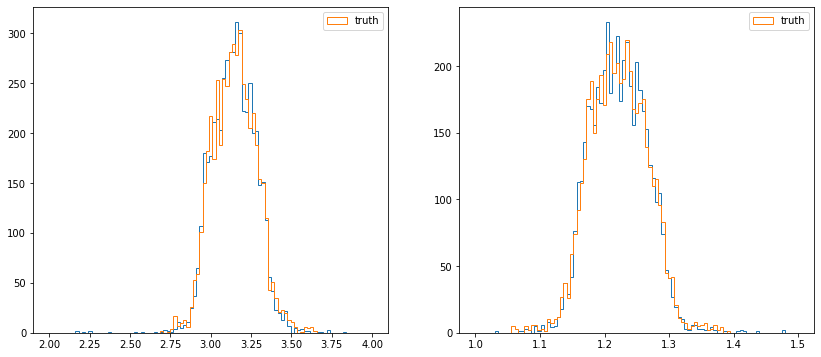

In [40]:
df = pd.read_csv('../gamma_dl3.csv').dropna()
print(len(df))

# _, lat, lon = cartesian_to_spherical(df.x.values, df.y.values, df.z.values)

# df['alt'] = lat.rad
# df['az'] = lon.rad

distance = calculate_distance_to_true_source_position(df)
# print(distance.std(), distance.mean())

print('Mine:')
print(lat.deg.mean(), lon.deg.mean())
# print(df.mc_alt.mean(), df.mc_alt.mean())

print('Theirs:')
print(np.rad2deg(df.mc_alt).mean(), np.rad2deg(df.mc_az.mean()))

bins  =np.linspace(2, 4, 100)
_, [ax1, ax2] = plt.subplots(1, 2, figsize=(14, 6))
ax1.hist(df.az, bins=bins, histtype='step')
ax1.hist(df.mc_az, bins=bins, histtype='step', label='truth')
ax1.legend()

bins  =np.linspace(1, 1.5, 100)
ax2.hist(df.alt, bins=bins, histtype='step')
ax2.hist(df.mc_alt, bins=bins, histtype='step', label='truth')
ax2.legend()
None

0.8776662379304038

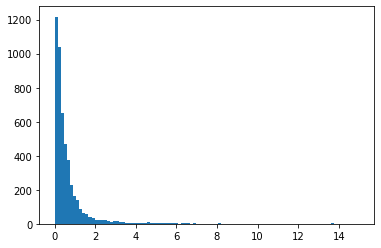

In [41]:
plt.hist(distance.to_value('deg'), bins=np.linspace(0, 15, 100))
distance.to_value('deg').mean()

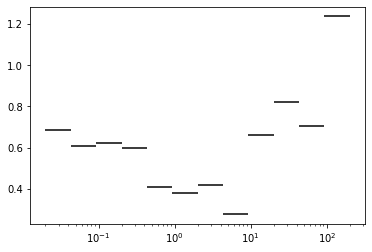

In [42]:
bins, _, _ = make_default_cta_binning(bins_per_decade=3)
b_68, bin_edges, _ = binned_statistic(df.mc_energy, distance.to_value('deg'), statistic=lambda y: np.nanpercentile(y, 68), bins=bins)
plt.hlines(b_68, bin_edges[:-1], bin_edges[1:])
plt.xscale('log')

In [39]:
from ctapipe.coordinates import CameraFrame, TelescopeFrame
from astropy.coordinates import SkyCoord, AltAz

In [723]:
from scipy.spatial.transform import Rotation as R

def to_horizontal(camera_coord, pointingPosition):
    
    pzd = 90 * u.deg - pointing.alt

    pzd = pzd.rad
    paz = pointing.az.rad
    
    x = camera_coord.cartesian.x
    y = camera_coord.cartesian.y
    
    fl = camera_coord.focal_length
    
    z = 1 / np.sqrt(1 + (x / fl)**2 + (y / fl)**2)

    x = -x * z / fl;
    y = y * z / fl;
    
    rAz = R.from_euler('z', -paz)
    rZd = R.from_euler('y', -pzd)
       # Rotation rotZAz = new Rotation(new Vector3D(0.0, 0.0, 1.0), -paz, RotationConvention.VECTOR_OPERATOR);
#     Rotation rotYZd = new Rotation(new Vector3D(0.0, 1.0, 0.0), -pzd, RotationConvention.VECTOR_OPERATOR);
    
    rotVec = rAz.inv().apply(rZd.inv().apply([x, y, z])) 
#     Vector3D rotVec = rotZAz.applyInverseTo(rotYZd.applyInverseTo(vec));
    
    rx, ry, rz = rotVec
    zd = np.arccos(rz);
    az = np.arctan2(ry, rx);

#     return 90 * u.deg - zd * u.rad, ((az + 2*np.pi) % (2*np.pi)) * u.rad
    if az < 0:
        az += 2*np.pi
    return 90 * u.deg - zd * u.rad, (az) * u.rad

In [732]:
pointing = SkyCoord(
    alt= 70 * u.deg,
    az=180 * u.deg,
    frame=AltAz(),
)

camera_frame = CameraFrame(
    focal_length=16 * u.m,
    telescope_pointing=pointing
)

cog_coord = SkyCoord(
    y=-0.5 * u.m,
    x=0.5 * u.m,
    frame=camera_frame,
)
cog_coord.transform_to(AltAz())

<SkyCoord (AltAz: obstime=None, location=None, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (174.28993439, 71.70660003)>

In [733]:
a, b = to_horizontal(cog_coord, pointing)
90 - a.to_value('deg'), b.to_value('deg')
# a, b

(18.294794414385066, 174.2922146614087)